In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse1 = 'SparseKO_02'
mouse2 = 'SparseKO_05'

d1 = sparse_sessions[mouse1][-1]
date1, scene1, session1, scan1 = d1['date'], d1['scene'], d1['session'], d1['scan']
d2 = sparse_sessions[mouse2][-1]
date2, scene2, session2, scan2 = d2['date'], d2['scene'], d2['session'], d2['scan']


pkldir1 = os.path.join('C:/Users/esay/data/Stx3/YMazeSessPkls', mouse1,  date1, f'{scene1}_{session1}.pkl')
pkldir2 = os.path.join('C:/Users/esay/data/Stx3/YMazeSessPkls', mouse2,  date2, f'{scene2}_{session2}.pkl')
sess1 = stx.session.YMazeSession.from_file(pkldir1, verbose=False)
sess2 = stx.session.YMazeSession.from_file(pkldir2, verbose=False)


In [3]:
trial_masks1 = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

trial_masks2 = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
channel_0_mask = sess1.trial_info['block_number']%2==0
left_mask1 = sess1.trial_info['LR']==-1
left_mask2 = sess2.trial_info['LR']==-1


trial_masks1['channel_0_left'] = channel_0_mask*left_mask1
trial_masks1['channel_0_right'] = channel_0_mask*(~left_mask1)
trial_masks1['channel_1_left'] = (~channel_0_mask)*left_mask1
trial_masks1['channel_1_right'] = (~channel_0_mask)*(~left_mask1)

trial_masks2['channel_0_left'] = channel_0_mask*left_mask2
trial_masks2['channel_0_right'] = channel_0_mask*(~left_mask2)
trial_masks2['channel_1_left'] = (~channel_0_mask)*left_mask2
trial_masks2['channel_1_right'] = (~channel_0_mask)*(~left_mask2)

# print(sess1.trial_info['LR'],left_mask)


In [4]:
# pc mask

chan0_mask_pf_left1 = sess1.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right1 = sess1.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left1 = sess1.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right1 = sess1.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask1 = chan1_mask_pf_left1 | chan1_mask_pf_right1
chan0_mask1 = chan0_mask_pf_left1 | chan0_mask_pf_right1

# pc mask2

chan0_mask_pf_left2 = sess2.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right2 = sess2.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left2 = sess2.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right2 = sess2.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask2 = chan1_mask_pf_left2 | chan1_mask_pf_right2
chan0_mask2 = chan0_mask_pf_left2 | chan0_mask_pf_right2

In [5]:
F = sess1.timeseries['channel_1_spks']
F_chan1_mask1 = F[chan1_mask1] 

F = sess1.timeseries['channel_0_spks']
F_chan0_mask1 = F[chan0_mask1]

F = sess2.timeseries['channel_1_spks']
F_chan1_mask2 = F[chan1_mask2] 

F = sess2.timeseries['channel_0_spks']
F_chan0_mask2 = F[chan0_mask2]

In [6]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [8]:
# shuffle1 pc only

rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}


F = F_chan0_mask1
starts, stops = sess1.trial_start_inds[trial_masks1['channel_0_left']], sess1.teleport_inds[trial_masks1['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess1.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan0_mask1
starts, stops = sess1.trial_start_inds[trial_masks1['channel_0_right']], sess1.teleport_inds[trial_masks1['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess1.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = F_chan1_mask1
starts, stops = sess1.trial_start_inds[trial_masks1['channel_1_left']], sess1.teleport_inds[trial_masks1['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess1.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan1_mask1
starts, stops = sess1.trial_start_inds[trial_masks1['channel_1_right']], sess1.teleport_inds[trial_masks1['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess1.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

In [9]:
# save shuffle1 pc only
with open('C://Users/esay/data/Stx3/YMazeSessPkls/pf_shuff_pc_only_SparseKO_02.pkl','wb') as file:
    pickle.dump(shuff_thresh,file)

In [12]:
# shuffle2 pc only 
rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}


F = F_chan0_mask2
starts, stops = sess2.trial_start_inds[trial_masks2['channel_0_left']], sess2.teleport_inds[trial_masks2['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess2.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan0_mask2
starts, stops = sess2.trial_start_inds[trial_masks2['channel_0_right']], sess2.teleport_inds[trial_masks2['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess2.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = F_chan1_mask2
starts, stops = sess2.trial_start_inds[trial_masks2['channel_1_left']], sess2.teleport_inds[trial_masks2['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess2.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = F_chan1_mask2
starts, stops = sess2.trial_start_inds[trial_masks2['channel_1_right']], sess2.teleport_inds[trial_masks2['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess2.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

In [13]:
# save shuffle2 pc only
with open('C://Users/esay/data/Stx3/YMazeSessPkls/pf_shuff_pc_only_SparseKO_05.pkl','wb') as file:
    pickle.dump(shuff_thresh,file)

In [14]:
#pc only 

shuff_02 = pd.read_pickle(r'C://Users/esay/data/Stx3/YMazeSessPkls/pf_shuff_pc_only_SparseKO_02.pkl')
shuff_05 = pd.read_pickle(r'C://Users/esay/data/Stx3/YMazeSessPkls/pf_shuff_pc_only_SparseKO_05.pkl')

In [6]:
rng = np.random.default_rng()
nperms = 1000

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_F_dff']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_0_F_dff']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)


F = sess.timeseries['channel_1_F_dff']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)

F = sess.timeseries['channel_1_F_dff']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(nperms)))
print(shuff_trial_mat.shape)
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 95, axis=0)




(1000, 30, 336)
(1000, 30, 336)
(1000, 30, 211)
(1000, 30, 211)


In [9]:
import pickle

with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_SparseKO_02.pkl','wb') as file:
    pickle.dump(shuff_thresh,file)

In [25]:
shuff_02 = pd.read_pickle(r'C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_SparseKO_02.pkl')
shuff_05 = pd.read_pickle(r'C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_SparseKO_05.pkl')

In [15]:

# pc only 

trial_means1 = {'channel_0_left': np.nanmean(sess1.trial_matrices['channel_0_spks'][trial_masks1['channel_0_left'], : , :][...,chan0_mask_pf_left1]),
               'channel_0_right': np.nanmean(sess1.trial_matrices['channel_0_spks'][trial_masks1['channel_0_right'], : , :][...,chan0_mask_pf_right1]),
               'channel_1_left': np.nanmean(sess1.trial_matrices['channel_1_spks'][trial_masks1['channel_1_left'], : , :][...,chan1_mask_pf_left1]),
               'channel_1_right': np.nanmean(sess1.trial_matrices['channel_1_spks'][trial_masks1['channel_1_right'], : , :][...,chan1_mask_pf_right1]),
              }

trial_means2 = {'channel_0_left': np.nanmean(sess2.trial_matrices['channel_0_spks'][trial_masks2['channel_0_left'], : , :][...,chan0_mask_pf_left2]),
               'channel_0_right': np.nanmean(sess2.trial_matrices['channel_0_spks'][trial_masks2['channel_0_right'], : , :][...,chan0_mask_pf_right2]),
               'channel_1_left': np.nanmean(sess2.trial_matrices['channel_1_spks'][trial_masks2['channel_1_left'], : , :][...,chan1_mask_pf_left2]),
               'channel_1_right': np.nanmean(sess2.trial_matrices['channel_1_spks'][trial_masks2['channel_1_right'], : , :][...,chan1_mask_pf_right2]),
              }

In [46]:
means

[{'channel_0_left': 0.012915725372238727,
  'channel_0_right': 0.010448308075009845,
  'channel_1_left': 0.017466739648411604,
  'channel_1_right': 0.01692106387509861},
 {'channel_0_left': 0.01303914633569101,
  'channel_0_right': 0.01408179479521016,
  'channel_1_left': 0.018547970595522247,
  'channel_1_right': 0.019829901742896002}]

In [16]:
ds = [shuff_02, shuff_05]

concat_shuff = {}

for k in shuff_02.keys():
    concat_shuff[k] = np.column_stack(list(concat_shuff[k] for concat_shuff in ds))

In [23]:
concat_shuff['channel_0_left'].shape

(30, 519)

In [52]:
means = [trial_means1, trial_means2]
trial_means = {}

for k in trial_means1.keys():
    trial_means[k] = np.column_stack(list(trial_means1[k] for trial_means1 in means))



In [53]:
trial_means

{'channel_0_left': array([[0.01291573, 0.01303915]]),
 'channel_0_right': array([[0.01044831, 0.01408179]]),
 'channel_1_left': array([[0.01746674, 0.01854797]]),
 'channel_1_right': array([[0.01692106, 0.0198299 ]])}

In [65]:
field_info1 = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_02.items():
    
    sig_bins = trial_means1[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
            field_info1[k].append([_ledge[1], _ledge[0], _redge[0][0]])


for k,v in field_info1.items():
    field_info1[k]=np.array(v)

In [66]:
field_info2 = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_05.items():
    
    sig_bins = trial_means2[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
            field_info2[k].append([_ledge[1], _ledge[0], _redge[0][0]])


for k,v in field_info2.items():
    field_info2[k]=np.array(v)

In [76]:
field_info1['channel_0_left'].shape

(140, 3)

In [81]:
field_info2['channel_0_left'].shape

(106, 3)

In [77]:
field_info = {key: np.concatenate([field_info1.get(key, np.empty((0, 3))), field_info2.get(key, np.empty((0, 3)))], axis=0) for key in field_info1.keys()}

In [79]:
field_info['channel_0_left'].shape

(246, 3)

(array([0.40217391, 0.40217391, 0.11956522, 0.07608696]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

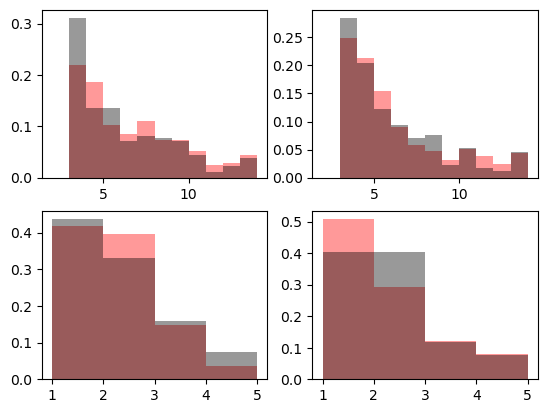

In [82]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    